#**TRANSFORMER IN RECOMMENDER SYSTEM**



The objective of the assignment is to exploit the self attention mechanism in a recommender system in order to seek an improvement from the model previously created in Assignment 1 and 2.

We decided to follow two approaches: one without the features and the second making use of them. In the former approach we developed two models: one based on multi-head attention and the other taking advantage of the transformer.
In the latter approach we combined the two previous models to enhance their capability to deal with the increased complexity of the problem.  

Regarding the dataset we followed the same procedure of the Assignment 2 except for the rating component. Previously we transformed ratings in 0 and 1 (seen/unseeen), while now we keep their original values.



##**SETTING ENVIRONMENT**

In [1]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
import torch.nn.init as init

In [2]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_origin = {'100k': 'u.data'}

num_sample_data = '100k'
DATA_PATH = '/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.data'.format(dataset_origin[num_sample_data]) #change this with your directory
MODEL_PATH = '/content/drive/MyDrive/machine learning/ML and DL/ml-100k'.format(num_sample_data) #change this with your directory


##**CLEANING THE DATASET**

*The cleaning dataset part is kept unchanged from the previous assignment and so are the comments.*


After adjusting the typos of the categorical values in the whole dataset, we removed 'IMDb_URL', 'release_date', 'video_release_date' and the 'title' features. In our opinion the Url and the title gave the same information of the item_id; the video release date contained NaN values only. For what concerns the release date, on 1682 films there were 240 release date different values only and neither NaN nor Null values. \\
In the dataframe, all the genres were hot-encoded (generating more then 40 different features). We decided to treat the genre as just 1 feature, each genre represented by an index. \\
For what concerns the occupations, we simply mapped the strings to indeces. \\
In the gender, we replaced 'M' as 1 and 'F' as 0. \\
The last important data manipulation was on the zip codes. We know that embedding layers require as num_embeddings argument the maximum possible value that can appear in that feature. The bigger this value, the more dimensions the embedding needs to work with. For this reason we decided to remap the zipcodes, in order to lighten the computations.

In [5]:
# Read u.data
data_columns = ['user_id', 'item_id', 'rating', 'timestamp']
data_df = pd.read_csv('/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.data', sep="\t", names=data_columns)

# Read u.user
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
user_df = pd.read_csv('/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.user', sep='|', names=user_columns)

# Read u.item
item_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_df = pd.read_csv('/content/drive/MyDrive/machine learning/ML and DL/ml-100k/u.item', sep='|', names=item_columns, encoding='latin-1')

# DataFrame creation
ml_100k = data_df
ml_100k = pd.merge(ml_100k, user_df, on='user_id')
ml_100k = pd.merge(ml_100k, item_df, on='item_id')


In [6]:
# Removing features
columns_to_remove = ['IMDb_URL','release_date','video_release_date','title']
ml_100k.drop(columns_to_remove, axis=1, inplace=True)

ml_100k.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,0,0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,0,0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,0,0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Genre manipulation
ml_100k_genre_df = ml_100k[['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
genre_new_df = pd.DataFrame()
genre_new_df['genre'] = ml_100k_genre_df.idxmax(axis=1)

# Mapping
mapping = {
    'unknown': 0,
    'Action': 1,
    'Adventure': 2,
    'Animation': 3,
    'Children': 4,
    'Comedy': 5,
    'Crime': 6,
    'Documentary': 7,
    'Drama': 8,
    'Fantasy': 9,
    'Film-Noir': 10,
    'Horror': 11,
    'Musical': 12,
    'Mystery': 13,
    'Romance': 14,
    'Sci-Fi': 15,
    'Thriller': 16,
    'War': 17,
    'Western': 18
}

genre_new_df['genre'] = genre_new_df['genre'].map(mapping)
colonne_to_remove = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ml_100k = ml_100k.drop(columns=colonne_to_remove)
ml_100k['genre'] = genre_new_df['genre']


In [8]:
# Zip code cleaning
ml_100k = ml_100k[ml_100k['zip_code'].str.contains(r'^\d{5}$')]

# Index reset
ml_100k = ml_100k.reset_index(drop=True)

In [9]:
# Gender mapping
ml_100k['gender'] = ml_100k['gender'].replace({'M': 1, 'F': 0})

In [10]:
# Occupation mapping
mapping = {
    'writer': 0,
    'programmer': 1,
    'executive': 2,
    'retired': 3,
    'marketing': 4,
    'student': 5,
    'educator': 6,
    'engineer': 7,
    'other': 8,
    'technician': 9,
    'scientist': 10,
    'artist': 11,
    'administrator': 12,
    'lawyer': 13,
    'homemaker': 14,
    'librarian': 15,
    'entertainment': 16,
    'healthcare': 17,
    'none': 18,
    'salesman': 19,
    'doctor': 20
}
ml_100k['occupation'] = ml_100k['occupation'].map(mapping)

In [11]:
# Zip code mapping
zip_code_rank = ml_100k['zip_code'].rank(method='dense').astype(int) - 1
zip_code_mapping = dict(zip(ml_100k['zip_code'].unique(), zip_code_rank.unique()))
ml_100k['zip_code'] = ml_100k['zip_code'].map(zip_code_mapping)

In [12]:
# Final results
ml_100k.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,genre
0,196,242,3,881250949,49,1,0,415,5
1,305,242,5,886307828,23,1,1,690,5
2,6,242,4,883268170,42,1,2,758,5
3,234,242,4,891033261,60,1,3,707,5
4,63,242,3,875747190,31,1,4,542,5


##**DATA MANAGEMENT**

We edited the Rating_Datset and NMF_Data classes to work with features and ratings.

We gave up the assumption that already seen movies deserve a positive rating (1)and unseen movies a negative one (0). The reason for the previous approximation was to simplify the task but now, using more advanced architectures, we want to challenge the model to recognise not a binary distinction between movies but, a more sophisticated distinction based on multiple values.  

Since we are now giving meaning to the ratings we need to give a meaning also to the unseen movies'. We chose to rate them at 2.5  out of 5 because we wanted to mimic a streaming platform: an unseen movie is not totally unliked but the user was not attracted to it (maybe beacuse of the graphic, the title, actors, ...). Therefore, the user expresses an opinion in not seeing a movie and this is reflected in the below average rating 2.5.   

In the train set, for each user, we put all the interactions except one, which goes in the test set. This interaction is not chosen as the last seen movie (as we did before) but as the last seen movie with rating 5 (or 4 if 5 not present). In this way, we can still use the metrics HR and NDCG based on distinguishing the best movie with respect to others. In the case in which neither 5 nor 4 were present we discarded the user (this led to get rid of just one user).

In the previous assignment we inserted 4 negative examples for each existing interaction, now this is not suitable anymore since it would lead to an highly unbalanced dataset. Before, the positive interactions were grouped all together under the same label. Now they are divided in 5 different labels. So we need to keep the rate label-to-label at an acceptable level.

Finally we needed to create coherence between the predictions of the model and the labels of tuples user-item, so we re-scaled the values 1-5 to 0.1-0.9. As a consequence we also modified the logistic function into a soft sigmoid by adding a parameter k defined in the parser as k = 0.5.



In [13]:
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list, age_list, gender_list, occupation_list, zip_code_list, genre_list):
		super(Rating_Datset, self).__init__()

		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list
		self.age_list = age_list
		self.gender_list = gender_list
		self.occupation_list = occupation_list
		self.zip_code_list = zip_code_list
		self.genre_list = genre_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		age = self.age_list[idx]
		gender = self.gender_list[idx]
		occupation = self.occupation_list[idx]
		zip_code = self.zip_code_list[idx]
		genre = self.genre_list[idx]

		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float),
	 		torch.tensor(age, dtype=torch.long),
			torch.tensor(gender, dtype=torch.long),
	 		torch.tensor(occupation, dtype=torch.long),
			torch.tensor(zip_code, dtype=torch.long),
	 		torch.tensor(genre, dtype=torch.long)
		)


In [14]:
# Creating a genre list in which each genre has the same index of the item index in the dataframe (see below: _find_genre() function)

genre_vec = []
unique_items = ml_100k['item_id'].unique()

for i in unique_items:
    row = ml_100k.loc[ml_100k['item_id'] == i]

    if not row.empty:
        genre_vec.append(row['genre'].iloc[0])
    else:
        genre_vec.append(None)

In [15]:
class NMF_Data(object):
    """
    Construct Dataset for NCF
    """
    def __init__(self, args, ratings):
        self.ratings = ratings
        self.num_ng = args.num_ng
        self.num_ng_test = args.num_ng_test

        self.preprocess_ratings = self._reindex(self.ratings)

        self.user_pool = set(self.ratings['user_id'].unique())
        self.item_pool = set(self.ratings['item_id'].unique())

        self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
        self.negatives = self._negative_sampling(self.preprocess_ratings)

    def _find_genre(self, item):
        return int(genre_vec[item])

    def _reindex(self, ratings):
        """
        Process dataset to reindex userID and itemID, also set rating as binary feedback
        """
        user_list = list(ratings['user_id'].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}

        item_list = list(ratings['item_id'].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}

        ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
        ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])

        return ratings

    def _leave_one_out(self, ratings):
        # Leave-one-out evaluation protocol

        # Select users who have rated movies with a rating of 4 or 5
        users_with_4_or_5 = ratings[ratings['rating'].isin([4, 5])]['user_id'].unique()
        # Filter the ratings to include only those from users who have given ratings of 4 or 5
        ratings = ratings[ratings['user_id'].isin(users_with_4_or_5)]

        # Separate ratings with a score of 5
        ratings_5 = ratings[ratings['rating'] == 5]
        # Rank the ratings based on timestamp, with the most recent rating getting rank 1
        ratings_5['rank_latest'] = ratings_5.groupby('user_id')['timestamp'].rank(method='first', ascending=False)
        # Select the most recent rating of 5 for each user
        test_5 = ratings_5.loc[ratings_5['rank_latest'] == 1]
        # Identify users who have given at least one rating of 5
        users_with_rating_5 = test_5['user_id'].unique()
        # Identify users who have not given any rating of 5
        users_without_rating_5 = ratings.loc[~ratings['user_id'].isin(users_with_rating_5)]['user_id'].unique()

        # Separate ratings with a score of 4 from users who haven't given any rating of 5
        ratings_4 = ratings[(ratings['rating'] == 4) & (ratings['user_id'].isin(users_without_rating_5))]
        # Rank the ratings based on timestamp, with the most recent rating getting rank 1
        ratings_4['rank_latest'] = ratings_4.groupby('user_id')['timestamp'].rank(method='first', ascending=False)
        # Select the most recent rating of 4 for each user
        test_4 = ratings_4.loc[ratings_4['rank_latest'] == 1]

        # Combine the test sets from ratings of 5 and 4
        test = pd.concat([test_5, test_4])

        # The training set is the complement of the test set
        train = ratings[~ratings.index.isin(test.index)]

        # Ensure that each user in the test set also appears in the training set
        assert train['user_id'].nunique() == test['user_id'].nunique(), 'Not Match Train User with Test User'

        # Return the training and test sets
        return train[['user_id', 'item_id', 'rating', 'age', 'gender', 'occupation', 'zip_code', 'genre']], test[['user_id', 'item_id', 'rating', 'age', 'gender', 'occupation', 'zip_code', 'genre']]

    def _negative_sampling(self, ratings):
        interact_status = (
            ratings.groupby('user_id')['item_id']
            .apply(set)
            .reset_index()
            .rename(columns={'item_id': 'interacted_items'}))
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))

        return interact_status[['user_id', 'negative_items', 'negative_samples']]

    def get_train_instance(self):
        users, items, ratings, age, gender, occupation, zip_code, genre = [], [], [], [], [], [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))

        for row in tqdm(train_ratings.itertuples()):
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating/5) - 0.1) #mapping the labels in 0.1-0.9
            age.append(int(row.age))
            gender.append(int(row.gender))
            occupation.append(int(row.occupation))
            zip_code.append(int(row.zip_code))
            genre.append(int(row.genre))

            for i in range(self.num_ng):
                users.append(int(row.user_id))
                items.append(int(row.negatives[i]))
                ratings.append(float(0.4)) # (2.5 / 5) - 0.1
                age.append(int(row.age))
                gender.append(int(row.gender))
                occupation.append(int(row.occupation))
                zip_code.append(int(row.zip_code))
                genre.append(int(self._find_genre(int(row.negatives[i]))))

        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings,
            age_list=age,
            gender_list=gender,
            occupation_list=occupation,
            zip_code_list=zip_code,
            genre_list=genre
        )
        print(dataset)
        return dataset

    def get_test_instance(self):
        users, items, ratings, age, gender, occupation, zip_code, genre = [], [], [], [], [], [], [], []
        test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')

        for row in test_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating/5) - 0.1) #mapping the labels in 0.1-0.9
            age.append(int(row.age))
            gender.append(int(row.gender))
            occupation.append(int(row.occupation))
            zip_code.append(int(row.zip_code))
            genre.append(int(row.genre))

            for i in getattr(row, 'negative_samples'):
                users.append(int(row.user_id))
                items.append(int(i))
                ratings.append(float(0.4))
                age.append(int(row.age))
                gender.append(int(row.gender))
                occupation.append(int(row.occupation))
                zip_code.append(int(row.zip_code))
                genre.append(int(self._find_genre(i)))

        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings,
            age_list=age,
            gender_list=gender,
            occupation_list=occupation,
            zip_code_list=zip_code,
            genre_list=genre
        )

        return dataset


In [16]:
def hit(ng_item, pred_items):
    if ng_item in pred_items:
        return 1
    return 0

def ndcg(ng_item, pred_items):
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index+2))
    return 0

def metrics(model, test_loader, top_k, device): # Metrics for models without features
    HR, NDCG = [], []

    for user, item, label, _, _, _, _, _ in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        ng_item = item[0].item() # leave one-out evaluation has only one item per user
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)

def metrics_feat(model, test_loader, top_k, device): # Metrics for models with features
    HR, NDCG = [], []

    for user, item, label, age, gender, occupation, zip_code, genre in test_loader:
        user = user.to(device)
        item = item.to(device)
        age = age.to(device)
        gender = gender.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)

        predictions = model(user, item, age, gender, occupation, zip_code, genre)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        ng_item = item[0].item() # leave one-out evaluation has only one item per user
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)


In [17]:
def plot_loss(hr, ndcg):
    plt.plot(range(len(hr)), hr, c='b', label='Hit Rate')
    plt.plot(range(len(ndcg)), ndcg, c='r', label='Normalized Discrete Cognitive Geometrical')
    plt.show()

In [18]:
#collapse-hide
parser = argparse.ArgumentParser()

parser.add_argument("--seed",
	type=int,
	default=42,
	help="Seed")
parser.add_argument("--lr_pre_training",
	type=float,
	default=0.0005,
	help="pre-training learning rate")
parser.add_argument("--lr",
	type=float,
	default=0.00025,
	help="learning rate")
parser.add_argument("--dropout_pre_training",
	type=float,
	default=0.2,
	help="pre-training dropout rate")
parser.add_argument("--dropout",
	type=float,
	default=0.6,
	help="dropout rate")
parser.add_argument("--batch_size_MLP",
	type=int,
	default=512,
	help="batch size for MLP pre-training")
parser.add_argument("--batch_size_GMF",
	type=int,
	default=1024,
	help="batch size for GMF pre-training")
parser.add_argument("--batch_size_NMF",
	type=int,
	default=512,
	help="batch size for training")
parser.add_argument("--batch_size_TRANS",
	type=int,
	default=512,
	help="batch size for transformer")
parser.add_argument("--epochs_pre_training",
	type=int,
	default=5,
	help="pre-training epoches")
parser.add_argument("--epochs",
	type=int,
	default=10,
	help="training epoches")
parser.add_argument("--top_k",
	type=int,
	default=10,
	help="compute metrics@top_k")
parser.add_argument("--factor_num",
	type=int,
	default=256,
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+',
    default=[512,64,256,32], #[args.factor_num * 2, int(args.factor_num / 4), args.factor_num, int(args.factor_num / 8)]
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--layers_mod_1",
    nargs='+',
    default=[256,32,128,16], #[args.factor_num * 2, int(args.factor_num / 4), args.factor_num, int(args.factor_num / 8)]
    help="MLP layers for model I. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng",
	type=int,
	default=1,
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test",
	type=int,
	default=99,
	help="Number of negative samples for test set")
parser.add_argument("--out",
	default=True,
	help="save model or not")
parser.add_argument("--num_heads",
	type=int,
	default=4,
	help="number of heads in multi head attention layers")
parser.add_argument("--k",
	type=float,
	default=0.5,
	help="sigmoid parameter to make it more linear")

args = parser.parse_args("")


In [19]:
data = NMF_Data(args, ml_100k)

data_train = data.get_train_instance()
data_test = data.get_test_instance()

<ipython-input-15-bd156d49c941>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_5['rank_latest'] = ratings_5.groupby('user_id')['timestamp'].rank(method='first', ascending=False)
<ipython-input-15-bd156d49c941>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_4['rank_latest'] = ratings_4.groupby('user_id')['timestamp'].rank(method='first', ascending=False)
<ipython-input-15-bd156d49c941>:81: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subse

# **MODELS WITHOUT FEATURES**

##**MODEL I**

Since the neural matrix factorization model consists of a combination of GMF and MLP, we decided to pre-train a GMF and an MLP model, as we did in the first assignment, to then load the pre-trained weight in the NeuMF model.

Both for MLP and GMF multi head attention has been used.
In the GMF we first compute the point wise product between the user and item embeddings. Then in parallel a self attention mechanism is performed on the same embeddings. Finally the two results are combined trough a point wise product.

Our idea is that in this way there is a combination of the classical GMF results with self attention benefits.

In MLP we directly pass trough the feed forward network the result of a self attention layer performed on the item and user embeddings.

The choice for the position of the self attention layer in both the model was justified by the wish of extracting complex relationships between the user and item embeddings.

The results are then treated as usual by the Neuf architecture.


<center>  <img src="https://drive.google.com/uc?export=view&id=1EnDcoHR-AVU3_Zye8UHDdc3F2xxmfU5k" width="780" height="1000"> </center>


###**Train GMF (with multi-head attention)**

In [20]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_GMF, shuffle=True, num_workers=4)
test_loader = DataLoader(data_test, batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
class GMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.num_heads = args.num_heads

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        init.xavier_normal_(self.embedding_user.weight)
        init.xavier_normal_(self.embedding_item.weight)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.factor_num, num_heads=self.num_heads)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        init.xavier_normal_(self.affine_output.weight)
        self.layer_norm = nn.LayerNorm(self.factor_num)

        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):

        #embedding
        user_embedding = self.embedding_user(user_indices).unsqueeze(0)
        item_embedding = self.embedding_item(item_indices).unsqueeze(0)

        # concatenation
        concat = torch.cat([user_embedding, item_embedding], dim=0)

        # attention
        attn_output, _  = self.multihead_attn(concat, concat, concat)
        attn_output = attn_output.mean(dim=0)
        attn_output = attn_output.squeeze(0)

        attn_output = self.layer_norm(attn_output)

        #point wise products
        element_product = torch.mul(user_embedding.squeeze(0), item_embedding.squeeze(0))
        element_product_tot = torch.mul(element_product, attn_output)

        logits = self.affine_output(element_product)
        rating = self.logistic(logits*args.k)
        return rating.squeeze()


In [22]:
# setting the model
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_items = ml_100k['item_id'].nunique() + 1
loss_list = []

model = GMF(args, num_users, num_items)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# training and eval
best_hr = 0

for epoch in range(1, args.epochs_pre_training + 1):
    model.train()
    start_time = time.time()
    total_loss = 0

    for user, item, label, _, _, _, _, _ in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
    scheduler.step()

    model.eval()
    HR, NDCG = metrics(model, test_loader, args.top_k, device)

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch:03d}, Time to train: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")
    print(f"HR: {np.mean(HR):.3f}\tNDCG: {np.mean(NDCG):.3f}")
    print(f"Loss: {avg_loss:.4f}")

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                       '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

print(f"Best Epoch: {best_epoch}, Best HR: {np.mean(best_hr):.3f}, Best NDCG: {np.mean(best_ndcg):.3f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001, Time to train: 00:00:27
HR: 0.120	NDCG: 0.059
Loss: 0.0356
Epoch 002, Time to train: 00:00:20
HR: 0.498	NDCG: 0.286
Loss: 0.0354
Epoch 003, Time to train: 00:00:20
HR: 0.575	NDCG: 0.326
Loss: 0.0319
Epoch 004, Time to train: 00:00:20
HR: 0.594	NDCG: 0.337
Loss: 0.0256
Epoch 005, Time to train: 00:00:21
HR: 0.618	NDCG: 0.358
Loss: 0.0234
Best Epoch: 5, Best HR: 0.618, Best NDCG: 0.358


###**Train MLP (with multi-head attention)**

In [23]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers_mod_1
        self.num_heads = args.num_heads

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.factor_num, num_heads=self.num_heads)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        for layer in self.fc_layers:
            init.xavier_normal_(layer.weight)

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        init.xavier_normal_(self.affine_output.weight)

        self.layer_norm = nn.LayerNorm(self.factor_num)

        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):

        # embeddings
        user_embedding = self.embedding_user(user_indices).unsqueeze(0)  # Adding sequence dimension
        item_embedding = self.embedding_item(item_indices).unsqueeze(0)  # Adding sequence dimension

        # concat
        concat = torch.cat([user_embedding, item_embedding], dim=0)

        # attention
        attn_output, _ = self.multihead_attn(concat, concat, concat)
        attn_output = attn_output.mean(dim=0)
        attn_output = self.layer_norm(attn_output)

        # Flatten the output to feed into the MLP
        vector = attn_output.view(attn_output.size(0), -1)

        # MLP
        for layer in self.fc_layers:
            vector = layer(vector)
            vector = nn.ReLU()(vector)
            vector = nn.Dropout(p=args.dropout_pre_training)(vector)

        # Output layer
        logits = self.affine_output(vector)
        rating = self.logistic(logits*args.k)
        return rating.squeeze()


In [24]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_MLP, shuffle=True, num_workers=4)
test_loader = DataLoader(data.get_test_instance(), batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

In [25]:
# setting the model
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_items = ml_100k['item_id'].nunique() + 1
loss_list = []

model = MLP(args, num_users, num_items)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# training and evaluation
best_hr = 0

for epoch in range(1, args.epochs_pre_training + 1):
    model.train()
    start_time = time.time()
    total_loss = 0

    for user, item, label, _, _, _, _, _ in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
    scheduler.step()

    model.eval()
    HR, NDCG = metrics(model, test_loader, args.top_k, device)

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch:03d}, Time to train: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")
    print(f"HR: {np.mean(HR):.3f}\tNDCG: {np.mean(NDCG):.3f}")
    print(f"Loss: {avg_loss:.4f}")

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                       '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

print(f"Best Epoch: {best_epoch}, Best HR: {np.mean(best_hr):.3f}, Best NDCG: {np.mean(best_ndcg):.3f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001, Time to train: 00:00:23
HR: 0.442	NDCG: 0.251
Loss: 0.0326
Epoch 002, Time to train: 00:00:21
HR: 0.499	NDCG: 0.272
Loss: 0.0277
Epoch 003, Time to train: 00:00:20
HR: 0.506	NDCG: 0.278
Loss: 0.0258
Epoch 004, Time to train: 00:00:22
HR: 0.494	NDCG: 0.265
Loss: 0.0245
Epoch 005, Time to train: 00:00:20
HR: 0.513	NDCG: 0.289
Loss: 0.0234
Best Epoch: 5, Best HR: 0.513, Best NDCG: 0.289


### **Train NMF**

In [26]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_NMF, shuffle=True, num_workers=4)
test_loader = DataLoader(data.get_test_instance(), batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

In [27]:
# Single models definition, used to load the weights learnt in the pre-training

class GMF_NMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF_NMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.num_heads = args.num_heads

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        init.xavier_normal_(self.embedding_user.weight)
        init.xavier_normal_(self.embedding_item.weight)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.factor_num, num_heads=self.num_heads)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        init.xavier_normal_(self.affine_output.weight)
        self.layer_norm = nn.LayerNorm(self.factor_num)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices).unsqueeze(0)
        item_embedding = self.embedding_item(item_indices).unsqueeze(0)

        concat = torch.cat([user_embedding, item_embedding], dim=0)

        attn_output, _  = self.multihead_attn(concat, concat, concat)
        attn_output = attn_output.mean(dim=0)
        attn_output = attn_output.squeeze(0)
        attn_output = self.layer_norm(attn_output)

        element_product = torch.mul(user_embedding.squeeze(0), item_embedding.squeeze(0))
        element_product_tot = torch.mul(element_product, attn_output)
        return element_product_tot

class MLP_NMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP_NMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers_mod_1
        self.num_heads = args.num_heads

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.factor_num, num_heads=self.num_heads)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        for layer in self.fc_layers:
            init.xavier_normal_(layer.weight)

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        init.xavier_normal_(self.affine_output.weight)

        self.layer_norm = nn.LayerNorm(self.factor_num)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices).unsqueeze(0)  # Adding sequence dimension
        item_embedding = self.embedding_item(item_indices).unsqueeze(0)  # Adding sequence dimension

        concat = torch.cat([user_embedding, item_embedding], dim=0)

        attn_output, _ = self.multihead_attn(concat, concat, concat)
        attn_output = attn_output.mean(dim=0)
        attn_output = self.layer_norm(attn_output)

        # Flatten the output to feed into the MLP
        vector = attn_output.view(attn_output.size(0), -1)

        # MLP
        for layer in self.fc_layers:
            vector = layer(vector)
            vector = nn.ReLU()(vector)
            vector = nn.Dropout(p=args.dropout)(vector)
        return vector

class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()

        self.GMFModel = GMF_NMF(args, num_users, num_items)
        self.MLPModel = MLP_NMF(args, num_users, num_items)

        self.GMFModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kGMF.pt", map_location=torch.device('cpu')), strict=False)
        self.MLPModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kMLP.pt", map_location=torch.device('cpu')), strict=False)

        self.affine_output = nn.Linear(in_features=args.layers_mod_1[-1]+args.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        # MLP PART
        MLP_res = self.MLPModel(user_indices, item_indices)

        # MF PART
        GMF_res = self.GMFModel(user_indices, item_indices)

        # Concatenation
        result = torch.cat([MLP_res, GMF_res], dim=-1)

        result = self.affine_output(result)

        result = self.logistic(result*args.k)

        return result.squeeze()



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001, Time to train: 00:00:23
HR: 0.601	NDCG: 0.333
Loss: 0.0240
Epoch 002, Time to train: 00:00:20
HR: 0.686	NDCG: 0.402
Loss: 0.0185
Epoch 003, Time to train: 00:00:23
HR: 0.702	NDCG: 0.426
Loss: 0.0149
Epoch 004, Time to train: 00:00:21
HR: 0.679	NDCG: 0.410
Loss: 0.0120
Epoch 005, Time to train: 00:00:23
HR: 0.675	NDCG: 0.412
Loss: 0.0098
Epoch 006, Time to train: 00:00:21
HR: 0.668	NDCG: 0.395
Loss: 0.0080
Epoch 007, Time to train: 00:00:23
HR: 0.652	NDCG: 0.389
Loss: 0.0066
Epoch 008, Time to train: 00:00:21
HR: 0.643	NDCG: 0.384
Loss: 0.0055
Epoch 009, Time to train: 00:00:23
HR: 0.642	NDCG: 0.380
Loss: 0.0046
Epoch 010, Time to train: 00:00:21
HR: 0.634	NDCG: 0.371
Loss: 0.0039
Best Epoch: 3, Best HR: 0.702, Best NDCG: 0.426


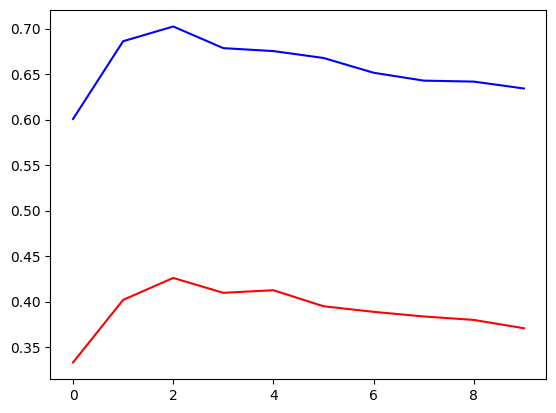

In [28]:
# setting the model
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_items = ml_100k['item_id'].nunique() + 1
loss_list = []
hr_list, ndcg_list = [], []

model = NeuMF(args, num_users, num_items)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# training and evaluation
best_hr = 0

for epoch in range(1, args.epochs + 1):
    model.train()
    start_time = time.time()
    total_loss = 0

    for user, item, label, _, _, _, _, _ in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
    scheduler.step()

    model.eval()
    HR, NDCG = metrics(model, test_loader, args.top_k, device)

    hr_list.append(HR)
    ndcg_list.append(NDCG)

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch:03d}, Time to train: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")
    print(f"HR: {np.mean(HR):.3f}\tNDCG: {np.mean(NDCG):.3f}")
    print(f"Loss: {avg_loss:.4f}")

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                       '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

print(f"Best Epoch: {best_epoch}, Best HR: {np.mean(best_hr):.3f}, Best NDCG: {np.mean(best_ndcg):.3f}")
plot_loss(hr_list, ndcg_list)


##**MODEL II**

In the Model I we used self attention in order to improve the performance of the single models GMF and MLP. Now, in Model II we want to improve the performance of the whole NeuMF by adding a third model to be combined with the unmodified GMF and MLP.
The main advantage lays in the presence of three branches which finds different relations and patterns between users and items. The transformer is able to find more complex and particular relations, but the MLP and GMF can contribute with  different and still valid points of view.

The transformer model is based on the application of the class nn.Transformer, taking as input the concatenation of the embeddings of user and item and, based on 2 encoder and 2 decoder layers, find relations in it. Then, with the application of a final linear layer, the output is obtained.




<center>  <img src="https://drive.google.com/uc?export=view&id=1IoAmSFZcDHhiJ9kkYSqihiLh_Oy4jGTd" width="900" height="950"> </center>

### **Train GMF**

In [29]:
class GMF_t(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF_t, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)
        init.xavier_normal_(self.embedding_user.weight)
        init.xavier_normal_(self.embedding_item.weight)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        init.xavier_normal_(self.affine_output.weight)

        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


In [30]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_GMF, shuffle=True, num_workers=4)
test_loader = DataLoader(data.get_test_instance(), batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

In [31]:

# set the num_users, items
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_items = ml_100k['item_id'].nunique() + 1
loss_list = []

# set model and loss, optimizer
model = GMF_t(args, num_users, num_items)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs_pre_training+1):
	model.train()
	start_time = time.time()
	loss_tmp = 0

	for user, item, label, _, _, _, _, _ in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss_tmp += loss.item()
		loss.backward()
		optimizer.step()

	loss_list.append(loss_tmp / len(train_loader))
	scheduler.step()

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " +
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model.state_dict(),
				'{}{}piva.pt'.format(MODEL_PATH, model.__class__.__name__))

	print(loss_list[-1])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001 time to train: 00: 00: 21
HR: 0.133	NDCG: 0.064
0.035576695948839186
Epoch 002 time to train: 00: 00: 19
HR: 0.521	NDCG: 0.290
0.03510195487423947
Epoch 003 time to train: 00: 00: 19
HR: 0.574	NDCG: 0.322
0.0292190519994811
Epoch 004 time to train: 00: 00: 20
HR: 0.609	NDCG: 0.353
0.023948617975570654
Epoch 005 time to train: 00: 00: 18
HR: 0.645	NDCG: 0.386
0.02143579473424899


### **Train MLP**

In [32]:
class MLP_t(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP_t, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num # num of neurons in hidden layers
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        for layer in self.fc_layers:
            init.xavier_normal_(layer.weight)

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        init.xavier_normal_(self.affine_output.weight)

        self.logistic = nn.Sigmoid()


    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)

        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()


In [33]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_MLP, shuffle=True, num_workers=4)
test_loader = DataLoader(data.get_test_instance(), batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

In [34]:
# set the num_users, items
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_items = ml_100k['item_id'].nunique() + 1
loss_list = []

# set model and loss, optimizer
model = MLP_t(args, num_users, num_items)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs_pre_training+1):
	model.train()
	start_time = time.time()
	loss_tmp = 0

	for user, item, label, _, _, _, _, _ in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss_tmp += loss.item()
		loss.backward()
		optimizer.step()

	loss_list.append(loss_tmp / len(train_loader))
	scheduler.step()

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " +
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model.state_dict(),
				'{}{}piva.pt'.format(MODEL_PATH, model.__class__.__name__))
	print(loss_list[-1])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001 time to train: 00: 00: 25
HR: 0.503	NDCG: 0.286
0.03130511168911464
Epoch 002 time to train: 00: 00: 19
HR: 0.525	NDCG: 0.286
0.025948058371493558
Epoch 003 time to train: 00: 00: 20
HR: 0.541	NDCG: 0.293
0.024163085544644056
Epoch 004 time to train: 00: 00: 19
HR: 0.528	NDCG: 0.292
0.023114466366399876
Epoch 005 time to train: 00: 00: 19
HR: 0.528	NDCG: 0.283
0.022211670084293724


###**Train TRANSFORMER**

In [35]:
class Transformer(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(Transformer, self).__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.dropout = args.dropout
        self.dropout_pre_training = args.dropout_pre_training

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.transformer = nn.Transformer(d_model=self.factor_num, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dropout=self.dropout_pre_training)
        self.fc = nn.Linear(self.factor_num, 1)
        self.dropout_layer = nn.Dropout(args.dropout_pre_training)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embeds = self.embedding_user(user_indices).unsqueeze(1)  # user_embeds.shape=[batch_size,1,factor_num]
        item_embeds = self.embedding_item(item_indices).unsqueeze(1)  # item_embeds.shape=[batch_size,1,factor_num]

        transformer_input = torch.cat((user_embeds, item_embeds), dim=1).transpose(0, 1) # transformer_input.shape=[2, batch_size,factor_num]
        transformer_output = self.transformer(transformer_input, transformer_input).mean(dim=0) # mean over dimension 0

        output = self.fc(self.dropout_layer(transformer_output)).squeeze(1) # remove dimension
        output = self.logistic(output)

        return output

In [36]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_TRANS, shuffle=True, num_workers=4)
test_loader = DataLoader(data.get_test_instance(), batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

In [37]:
# setting the model
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_items = ml_100k['item_id'].nunique() + 1
loss_list = []

model = Transformer(args, num_users, num_items)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr_pre_training)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# training and evaluation
best_hr = 0

for epoch in range(1, args.epochs_pre_training + 1):
    model.train()
    start_time = time.time()
    loss_tmp = 0
    total_loss = 0

    for user, item, label, _, _, _, _, _ in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
    scheduler.step()

    model.eval()
    HR, NDCG = metrics(model, test_loader, args.top_k, device)

    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch:03d}, Time to train: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")
    print(f"HR: {np.mean(HR):.3f}\tNDCG: {np.mean(NDCG):.3f}")
    print(f"Loss: {avg_loss:.4f}")

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                       '{}{}piva.pt'.format(MODEL_PATH, model.__class__.__name__))

print(f"Best Epoch: {best_epoch}, Best HR: {np.mean(best_hr):.3f}, Best NDCG: {np.mean(best_ndcg):.3f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001, Time to train: 00:00:31
HR: 0.557	NDCG: 0.317
Loss: 0.0330
Epoch 002, Time to train: 00:00:30
HR: 0.560	NDCG: 0.318
Loss: 0.0258
Epoch 003, Time to train: 00:00:29
HR: 0.562	NDCG: 0.317
Loss: 0.0245
Epoch 004, Time to train: 00:00:30
HR: 0.568	NDCG: 0.323
Loss: 0.0236
Epoch 005, Time to train: 00:00:30
HR: 0.555	NDCG: 0.316
Loss: 0.0226
Best Epoch: 4, Best HR: 0.568, Best NDCG: 0.323


### **Train NMF**

In [38]:
class GMF_NMF_t(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF_NMF_t, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)

        return element_product

class MLP_NMF_t(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP_NMF_t, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for i in range(len(self.layers) - 1): #idx, (in_size, out_size) in enumerate(zip(self.layers_MLP[:-1], self.layers_MLP[1:])):
            self.fc_layers.append(nn.Linear(self.layers[i], self.layers[i+1]))


        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = F.elu(vector)

            vector = nn.Dropout(p=args.dropout)(vector)

        return vector

class Transformer_NMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(Transformer_NMF, self).__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num # num of neurons in hidden layers
        self.dropout = args.dropout

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.transformer = nn.Transformer(d_model=self.factor_num, nhead=8, num_encoder_layers=1, num_decoder_layers=1, dropout=self.dropout)
        self.dropout_layer = nn.Dropout(args.dropout)

    def forward(self, user_indices, item_indices):
        user_embeds = self.embedding_user(user_indices).unsqueeze(1)
        item_embeds = self.embedding_item(item_indices).unsqueeze(1)

        transformer_input = torch.cat((user_embeds, item_embeds), dim=1).transpose(0, 1)
        transformer_output = self.transformer(transformer_input, transformer_input).mean(dim=0)

        return transformer_output

class NeuMF_t(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF_t, self).__init__()

        self.GMFModel = GMF_NMF_t(args, num_users, num_items)
        self.MLPModel = MLP_NMF_t(args, num_users, num_items)
        self.TransformerModel = Transformer_NMF(args, num_users, num_items)

        self.GMFModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kGMF_tpiva.pt", map_location=torch.device('cpu')))
        self.MLPModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kMLP_tpiva.pt", map_location=torch.device('cpu')))
        self.TransformerModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kTransformerpiva.pt", map_location=torch.device('cpu')), strict=False)

        self.affine_output = nn.Linear(in_features=self.GMFModel.factor_num + args.layers[-1] + self.TransformerModel.factor_num, out_features=1)

        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        # MLP PART
        MLP_res = self.MLPModel(user_indices, item_indices)

        # MF PART
        GMF_res = self.GMFModel(user_indices, item_indices)

        # TRANSFORMER PART
        Transformer_res = self.TransformerModel(user_indices, item_indices)

        # Concatenation
        result = torch.cat([MLP_res, GMF_res, Transformer_res], dim=-1)

        result = self.affine_output(result)

        result = self.logistic(result)

        return result.squeeze()


In [39]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_NMF, shuffle=True, num_workers=4)
test_loader = DataLoader(data.get_test_instance(), batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001 time to train: 00:00:25
HR: 0.555	NDCG: 0.319
tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 002 time to train: 00:00:24
HR: 0.585	NDCG: 0.340
tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 003 time to train: 00:00:25
HR: 0.615	NDCG: 0.361
tensor(0.0202, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 004 time to train: 00:00:25
HR: 0.628	NDCG: 0.380
tensor(0.0185, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 005 time to train: 00:00:24
HR: 0.649	NDCG: 0.399
tensor(0.0171, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 006 time to train: 00:00:23
HR: 0.671	NDCG: 0.418
tensor(0.0159, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 007 time to train: 00:00:25
HR: 0.681	NDCG: 0.427
tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 008 time to train: 00:00:26
HR: 0.686	NDCG: 0.432
tensor(0.0138, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 009 time to train: 00:00:25
HR: 0.703	NDCG: 0.440
tensor(0.0129, device='cuda:0', grad_fn=<DivBack

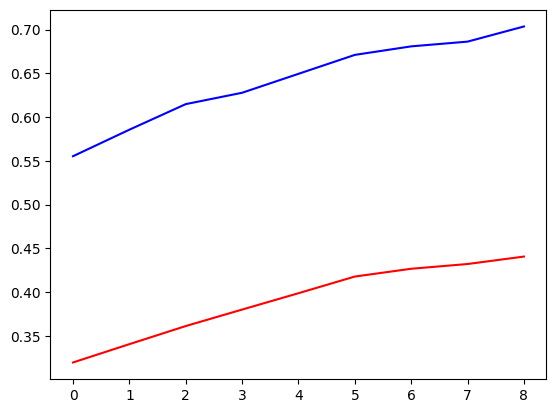

In [40]:
# set the num_users, items
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_items = ml_100k['item_id'].nunique() + 1
loss_list = []
hr_list = []
ndcg_list = []

# set model and loss, optimizer
model = NeuMF_t(args, num_users, num_items)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs):
    model.train()
    start_time = time.time()
    loss_tmp = 0

    for user, item, label, _, _, _, _, _ in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss_tmp += loss
        loss.backward()
        optimizer.step()

    loss_list.append(loss_tmp / len(train_loader))
    scheduler.step()

    model.eval()
    HR, NDCG = metrics(model, test_loader, args.top_k, device)

    hr_list.append(HR)
    ndcg_list.append(NDCG)

    elapsed_time = time.time() - start_time
    print("Epoch {:03d}".format(epoch) + " time to train: " +
          time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(), '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))
    print(loss_list[-1])

plot_loss(hr_list, ndcg_list)

# **MODEL WITH FEATURES**

This model is a combination of Model I and II. To integrate the features we decided to use the previously trained branches of GMF, MLP and Transformer with in addition a new branch taking into account the features. Here, at first we create the embeddings and then we apply the concatenation and the multihead attention layer with user and item. Once all the branches have the respective output, the result is concatenated and feed into a final dense layer.

Following the same reasoning as before, we put the self attention in such a way that the model is able to extract relationships between the embeddings.

<center>  <img src="https://drive.google.com/uc?export=view&id=1RBDDjx9bqLQiVtyAWMgMJRNAKXodd9Je" width="1000" height="1000"> </center>

##**NMF**

In [58]:
class NeuMF_Completed(nn.Module):
    def __init__(self, args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre):
        super(NeuMF_Completed, self).__init__()

        self.GMFModel = GMF_NMF(args, num_users, num_items)
        self.MLPModel = MLP_NMF(args, num_users, num_items)
        self.TransformerModel = Transformer_NMF(args, num_users, num_items)

        self.GMFModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kGMF.pt", map_location=torch.device('cpu')))
        self.MLPModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kMLP.pt", map_location=torch.device('cpu')))
        self.TransformerModel.load_state_dict(torch.load("/content/drive/MyDrive/machine learning/ML and DL/ml-100kTransformerpiva.pt", map_location=torch.device('cpu')), strict=False)

        self.num_users = num_users
        self.num_items = num_items
        self.num_age = num_age
        self.num_gender = num_gender
        self.num_occupation = num_occupation
        self.num_zip_code = num_zip_code
        self.num_genre = num_genre

        self.num_heads = args.num_heads
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.emb1=nn.Embedding(num_embeddings=self.num_age, embedding_dim=2)
        self.emb2=nn.Embedding(num_embeddings=self.num_gender, embedding_dim=2)
        self.emb3=nn.Embedding(num_embeddings=self.num_occupation, embedding_dim=8)
        self.emb4=nn.Embedding(num_embeddings=self.num_zip_code, embedding_dim=8)
        self.emb5=nn.Embedding(num_embeddings=self.num_genre, embedding_dim=8)

        self.affine_output = nn.Linear(in_features=2 * args.factor_num+args.layers_mod_1[-1]+540, out_features=1) # last mlp layer + fac number * 3
        self.logistic = nn.Sigmoid()

        self.layer_norm = nn.LayerNorm(2*args.factor_num+28)

        self.multihead = nn.MultiheadAttention(embed_dim=540, num_heads=args.num_heads)

    def forward(self, user_indices, item_indices, age_indices, gender_indices, occupation_indices, zip_code_indices, genre_indices):

        # MLP PART

        MLP_res = self.MLPModel(user_indices, item_indices)

        # MF PART

        GMF_res = self.GMFModel(user_indices, item_indices)

        # Transformer part

        Transformer_res = self.TransformerModel(user_indices, item_indices)

        # feature part

        age_emb = self.emb1(age_indices).unsqueeze(0)
        gender_emb = self.emb2(gender_indices).unsqueeze(0)
        occupation_emb = self.emb3(occupation_indices).unsqueeze(0)
        zip_code_emb = self.emb4(zip_code_indices).unsqueeze(0)
        genre_emb = self.emb5(genre_indices).unsqueeze(0)

        user_emb = self.embedding_user(user_indices).unsqueeze(0)
        item_emb = self.embedding_item(item_indices).unsqueeze(0)

        emb = torch.cat([user_emb, item_emb, age_emb, gender_emb, occupation_emb, zip_code_emb, genre_emb], dim=2)

        attn_feat, _ = self.multihead(emb, emb, emb)
        attn_feat = attn_feat.mean(dim=0).squeeze(0)
        attn_feat = self.layer_norm(attn_feat)

        # FINAL RESULT

        result = torch.cat([MLP_res, GMF_res, Transformer_res, attn_feat], dim=-1)

        result = self.affine_output(result)

        result = self.logistic(result * args.k)

        return result.squeeze()


**NMF Training**

In [42]:
train_loader = DataLoader(data_train, batch_size=args.batch_size_NMF, shuffle=True, num_workers=4)
test_loader = DataLoader(data.get_test_instance(), batch_size=args.num_ng_test+1, shuffle=False, num_workers=2)

  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 001 time to train: 00: 00: 30
HR: 0.573	NDCG: 0.314 



 20%|██        | 2/10 [01:04<04:18, 32.32s/it]


 Epoch 002 time to train: 00: 00: 32
HR: 0.589	NDCG: 0.328 



 30%|███       | 3/10 [01:36<03:44, 32.05s/it]


 Epoch 003 time to train: 00: 00: 31
HR: 0.635	NDCG: 0.366 



 40%|████      | 4/10 [02:14<03:27, 34.59s/it]


 Epoch 004 time to train: 00: 00: 38
HR: 0.635	NDCG: 0.368 



 50%|█████     | 5/10 [02:55<03:03, 36.60s/it]


 Epoch 005 time to train: 00: 00: 40
HR: 0.659	NDCG: 0.377 



 60%|██████    | 6/10 [03:30<02:25, 36.28s/it]


 Epoch 006 time to train: 00: 00: 35
HR: 0.665	NDCG: 0.383 



 70%|███████   | 7/10 [04:05<01:47, 35.72s/it]


 Epoch 007 time to train: 00: 00: 34
HR: 0.668	NDCG: 0.383 



 80%|████████  | 8/10 [04:45<01:14, 37.29s/it]


 Epoch 008 time to train: 00: 00: 40
HR: 0.674	NDCG: 0.388 



 90%|█████████ | 9/10 [05:25<00:38, 38.07s/it]


 Epoch 009 time to train: 00: 00: 39
HR: 0.676	NDCG: 0.383 



100%|██████████| 10/10 [06:07<00:00, 36.72s/it]


 Epoch 010 time to train: 00: 00: 41
HR: 0.672	NDCG: 0.383 



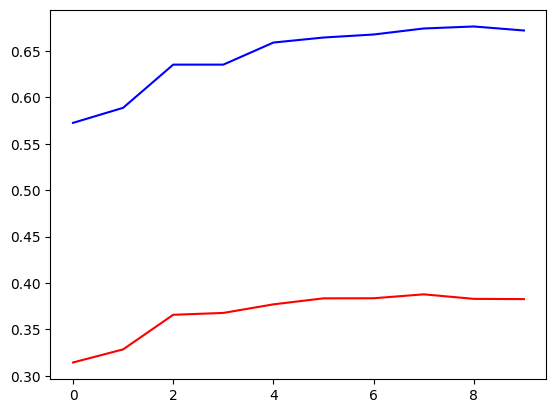

In [59]:
num_items = ml_100k['item_id'].nunique() + 1
num_users = len(np.unique(np.array(data_train[:][0]))) + 1
num_age = int(ml_100k['age'].max() + 1)
num_occupation = int(ml_100k['occupation'].max()) + 1
num_zip_code = int(ml_100k['zip_code'].max()) + 1
num_genre = int(ml_100k['genre'].max()) + 1
num_gender = int(ml_100k['gender'].max()) + 1

# set model and loss, optimizer
model = NeuMF_Completed(args, num_users, num_items, num_age, num_gender, num_occupation, num_zip_code, num_genre)
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.95)

# train, evaluation
hr_evolution = []
ndcg_evolution = []
loss_evolution = []

best_hr = 0
for epoch in tqdm(range(1, args.epochs+1)):
    model.train()
    start_time = time.time()

    for user, item, label, age, gender, occupation, zip_code, genre in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        age = age.to(device)
        occupation = occupation.to(device)
        zip_code = zip_code.to(device)
        genre = genre.to(device)
        gender = gender.to(device)

        optimizer.zero_grad()
        prediction = model(user, item, age, gender, occupation, zip_code, genre)

        loss = loss_function(prediction, label)
        loss_evolution.append(loss)
        loss.backward()
        optimizer.step()

    scheduler.step()

    model.eval()
    HR, NDCG = metrics_feat(model, test_loader, args.top_k, device)

    elapsed_time = time.time() - start_time
    print("\n Epoch {:03d}".format(epoch) + " time to train: " +
          time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)), "\n")

    hr_evolution.append(HR)
    ndcg_evolution.append(NDCG)

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model.state_dict(),
                       '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

plot_loss(hr_evolution, ndcg_evolution)


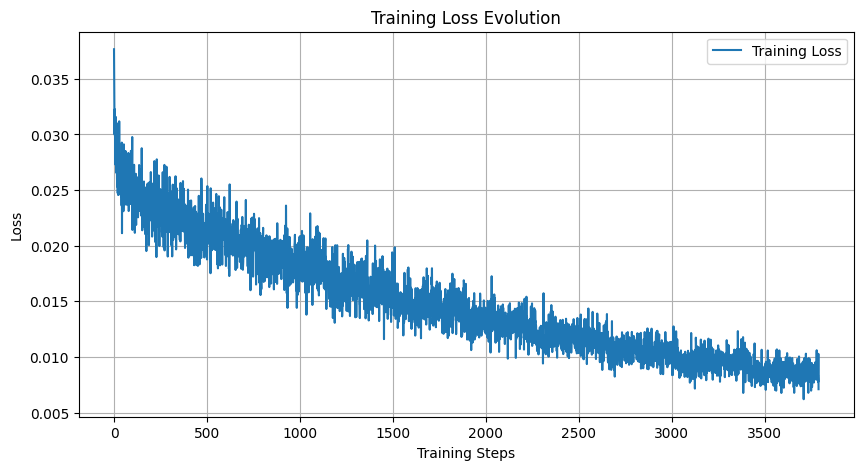

In [60]:
loss_evolution_floats = [loss.item() for loss in loss_evolution]

# Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(loss_evolution_floats, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Evolution')
plt.legend()
plt.grid(True)
plt.show()


# CONCLUSIONS

In the following, the results reached with our previous models (previous assignments) are reported:

WITHOUT FEATURES (HR, NDCG):
- GMF: 0.709, 0.392
- MLP: 0.562, 0.323
- NMF: 0.706, 0.421

WITH FEATURES (HR, NDCG):
- NMF: 0.599, 0.353

Now, we present the results obtained through self attention mechanism:

WITHOUT FEATURES (HR, NDCG):
- GMF: 0.618, 0.358
- MLP: 0.513, 0.289
- NMF: 0.702, 0.426
- TRANS: 0.568, 0.323
- NMF_t: 0.703, 0.440

WITH FEATURES (HR, NDCG):
- NMF: 0.676, 0.388


It's important to notice that the results obtained with the models from the previous assignments were obtained giving a high importance to the fine-tuning of the model parameteres and moreover with a huge approximation of the task (using ratings as 0 and 1). Now, we reached similar results in few epochs with little research of parameters and we are also losing the approximation of the ratings, increasing the complexity of the task.

We are aware that the scarse usage of a totally sequenced approach has penalized our models and should be taken into account for further developments.